### Example of expected power module usage

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from scada_data_analysis.modules.expected_power import ExpectedPower

### Explore the data

In [2]:
#load the data
scada_df = pd.read_csv(r'../datasets/la-haute-borne-data-2017-2020.zip', sep=';')

# Inspect data head
scada_df.head()

,Wind_turbine_name,Date_time,Ba_avg,Ba_min,Ba_max,Ba_std,Rt_avg,Rt_min,Rt_max,Rt_std,...,Pas_max,Pas_std,Wa_c_avg,Wa_c_min,Wa_c_max,Wa_c_std,Na_c_avg,Na_c_min,Na_c_max,Na_c_std
0,R80721,2017-02-08T08:00:00+01:00,44.990002,44.990002,44.990002,0.0,14.0,14.0,14.0,0.0,...,NaN,NaN,358.04999,NaN,NaN,NaN,358.04999,NaN,NaN,NaN
1,R80721,2017-01-26T02:40:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R80721,2017-01-26T13:50:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R80721,2017-01-26T15:00:00+01:00,-1.000000,-1.000000,-1.000000,0.0,10.0,10.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R80721,2017-02-18T01:10:00+01:00,44.990002,44.990002,44.990002,0.0,17.0,17.0,17.0,0.0,...,NaN,NaN,7.99000,NaN,NaN,NaN,7.99000,NaN,NaN,NaN


In [3]:
# Inspect data shape
scada_df.shape

(217588, 138)

In [4]:
# Unique turbine count
scada_df['Wind_turbine_name'].unique()

array(['R80721', 'R80790', 'R80736', 'R80711'], dtype=object)

In [5]:
# Earliest time stamp
scada_df['Date_time'].min()

'2017-01-01T00:00:00+01:00'

In [6]:
# Latest time stamp
scada_df['Date_time'].max()

'2018-01-13T00:00:00+01:00'

##### Perform correlation analysis based on power output

In [7]:
df_R80721 = scada_df[scada_df['Wind_turbine_name'] == 'R80721'][['Date_time', 'P_avg']]
df_R80790 = scada_df[scada_df['Wind_turbine_name'] == 'R80790'][['Date_time', 'P_avg']]
df_R80736 = scada_df[scada_df['Wind_turbine_name'] == 'R80736'][['Date_time', 'P_avg']]
df_R80711 = scada_df[scada_df['Wind_turbine_name'] == 'R80711'][['Date_time', 'P_avg']]

In [8]:
df_R80721.columns = ['Date_time', 'R80721']
df_R80790.columns = ['Date_time', 'R80790']
df_R80736.columns = ['Date_time', 'R80736']
df_R80711.columns = ['Date_time', 'R80711']

In [9]:
scada_df['Wind_turbine_name'].value_counts()

R80721    54433
R80736    54433
R80711    54433
R80790    54289
Name: Wind_turbine_name, dtype: int64

In [10]:
df_R80736.shape

(54433, 2)

In [11]:
df_list = [df_R80721, df_R80790, df_R80736, df_R80711]

In [12]:
%%time
from functools import reduce

df_merged = reduce(lambda  left,right: pd.merge(left, right, on=['Date_time'],
                                            how='outer'), df_list)

CPU times: total: 109 ms
Wall time: 97 ms


In [13]:
df_merged.dropna(inplace=True)
df_merged.reset_index(drop=True, inplace=True)

In [14]:
df_merged.columns

Index(['Date_time', 'R80721', 'R80790', 'R80736', 'R80711'], dtype='object')

In [15]:
corr = df_merged[['R80721', 'R80790', 'R80736', 'R80711']].corr()

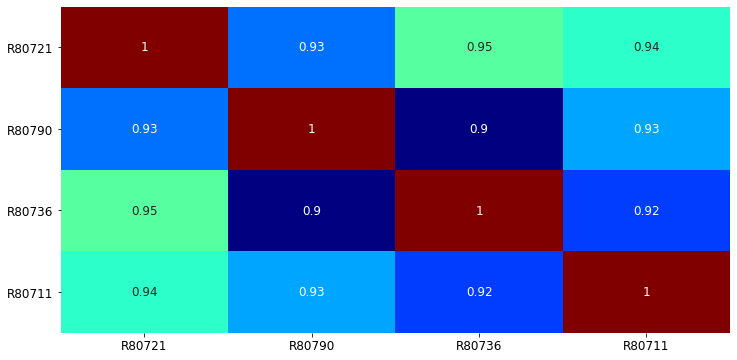

In [17]:
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True, cmap='jet', annot_kws={"fontsize":12}, cbar=False);
plt.xticks(fontsize=12)
plt.yticks(rotation='horizontal', fontsize=12);

### Data Processing

In [7]:
# select required clumns
scada_df = scada_df[['Date_time', 'Wind_turbine_name', 'Ws_avg', 'P_avg']]
scada_df.head()

,Date_time,Wind_turbine_name,Ws_avg,P_avg
0,2017-02-08T08:00:00+01:00,R80721,0.18,-1.89000
1,2017-01-26T02:40:00+01:00,R80721,4.85,197.32001
2,2017-01-26T13:50:00+01:00,R80721,5.04,176.45000
3,2017-01-26T15:00:00+01:00,R80721,5.31,190.61000
4,2017-02-18T01:10:00+01:00,R80721,3.15,-2.88000


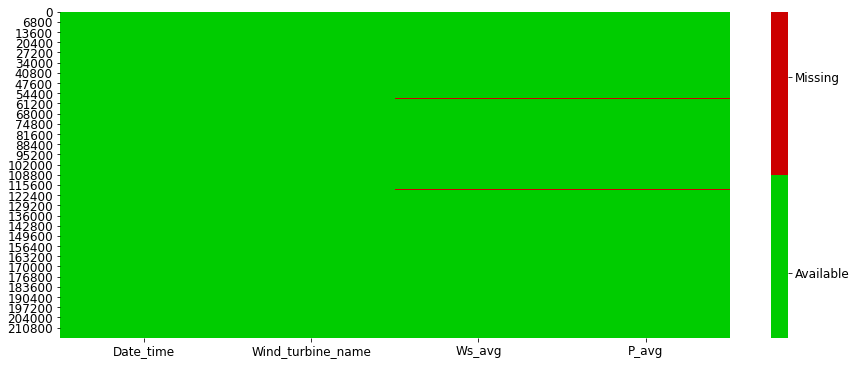

In [8]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap

myColors = ((0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

# Plot heatmap
plt.figure(figsize=(15,6))
ax = sns.heatmap(scada_df.isna().astype(int)+1, cmap=cmap);

# Post-process visualization
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1.2, 1.8])
colorbar.set_ticklabels(['Available', 'Missing'], fontsize=12)

In [9]:
# Remove rows missing values
original_length = scada_df.shape[0]
scada_df.dropna(inplace=True)
scada_df.reset_index(drop=True)
print(f'{round((original_length-scada_df.shape[0])/original_length*100, 2)}% of original rows were removed')

0.76% of original rows were removed


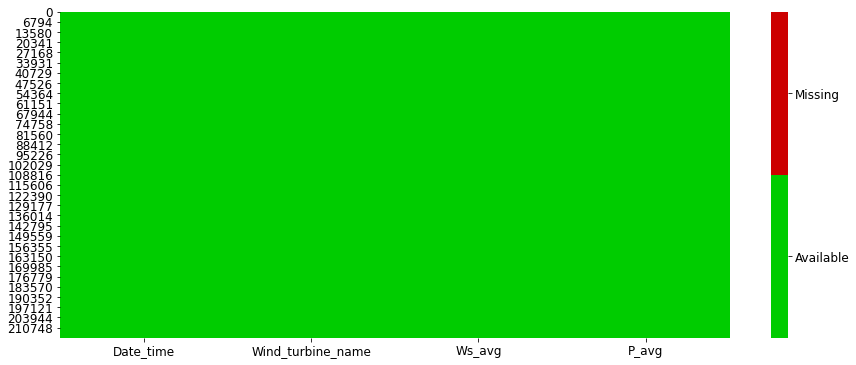

In [10]:
myColors = ((0.0, 0.8, 0.0, 1.0), (0.8, 0.0, 0.0, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

plt.figure(figsize=(15,6))
ax = sns.heatmap(scada_df.isna().astype(int)+1, cmap=cmap);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.95, 1.05])
colorbar.set_ticklabels(['Available', 'Missing'], fontsize=12)

In [11]:
train_df = scada_df[scada_df['Date_time'] < '2017-09-22']
train_df_ind = train_df.index
test_df_ind = list(set(scada_df.index).difference(set(train_df_ind)))
test_df = scada_df.loc[test_df_ind,:]

In [12]:
assert len(train_df) + len(test_df) == len(scada_df), 'Data split mismatch'

In [13]:
print(f'Training data is {round(len(train_df)/len(scada_df) * 100)}% of original data')

Training data is 70% of original data


### Data Exploration

In [14]:
train_df.reset_index(drop=True, inplace=True)
train_df.shape

(151261, 4)

In [15]:
test_df.reset_index(drop=True, inplace=True)
test_df.shape

(64669, 4)

### Test Expected Power Module

In [16]:
power_model = ExpectedPower(turbine_label='Wind_turbine_name', windspeed_label='Ws_avg',
                            power_label='P_avg', method='binning', kind='cubic')

In [17]:
%%time
power_model = power_model.fit(train_df)

CPU times: total: 2.97 s
Wall time: 2.96 s


In [18]:
%%time
pred_df = test_df.copy()
pred_df['expected_power_linear'] = power_model.predict(test_df)['expected_power']

CPU times: total: 46.9 ms
Wall time: 56 ms


In [19]:
%%time
pred_df['expected_power_quad'] = power_model.predict(test_df)['expected_power']

CPU times: total: 46.9 ms
Wall time: 46 ms


In [20]:
%%time
pred_df['expected_power_cubic'] = power_model.predict(test_df)['expected_power']

CPU times: total: 46.9 ms
Wall time: 42 ms


##### Root mean square metric

In [21]:
#linear
mean_squared_error(pred_df.P_avg.values, pred_df.expected_power_linear.values, squared=False)

118.25716853367274

In [22]:
#quad
mean_squared_error(pred_df.P_avg.values, pred_df.expected_power_quad.values, squared=False)

118.25716853367274

In [23]:
#cubic
mean_squared_error(pred_df.P_avg.values, pred_df.expected_power_cubic.values, squared=False)

118.25716853367274

### Save the prediction data

In [24]:
# pred_df.to_excel(r'..\predictions.xlsx', index=False)